In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

from torch import nn

In [2]:
transform = T.Compose([T.ToTensor()])
train_set = torchvision.datasets.MNIST(root="../data/raw", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../data/raw", train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/raw\MNIST\raw\train-images-idx3-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/raw\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%


Extracting ../data/raw\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/raw\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100.0%

Extracting ../data/raw\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/raw\MNIST\raw



In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    print("Device used:", torch.cuda.get_device_name(0))
else:
    print("No GPU available: Using CPU")

input_dim = 784
z_dim = 20
h_dim = 200

class AE(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim):
        super().__init__()
        self.common = nn.Linear(input_dim, h_dim)
        self.encoded = nn.Linear(h_dim, z_dim)
        self.l1 = nn.Linear(z_dim, h_dim)
        self.decode = nn.Linear(h_dim, input_dim)

    def encoder(self, x):
        common = F.relu(self.common(x))
        mu = self.encoded(common)

        return mu
    
    def decoder(self, z):
        out = F.relu(self.l1(z))
        out = torch.sigmoid(self.decode(out))

        return out
    
    def forward(self, x):
        mu = self.encoder(x)
        out = self.decoder(mu)

        return out, mu

Device used: NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:
model = AE(input_dim, z_dim, h_dim).to(device)
lr = 0.00025
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [6]:
originals = []
idx = 0

for img, label in test_set:
    if label == idx:
        originals.append(img)
        idx += 1

    if idx == 10:
        break

def plot_digits():
    reconstructed = []

    for idx in range(10):
        with torch.no_grad():
            img = originals[idx].reshape((1, input_dim))
            out, mu = model(img.to(device))

        reconstructed.append(out)

    imgs = originals + reconstructed

    plt.figure(figsize=(10, 2), dpi=50)

    for i in range(20):
        ax = plt.subplot(2, 10, i + 1)
        img = (imgs[i].detach().cpu().numpy())

        plt.imshow(img.reshape(28, 28), cmap="binary")
        plt.xticks([])
        plt.yticks([])

    plt.show()

At epoch 0 total loss = 1010.2286553873698


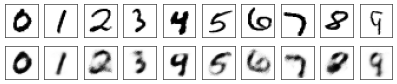

At epoch 1 total loss = 470.4605744954427


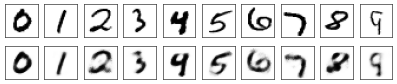

At epoch 2 total loss = 379.60082810872393


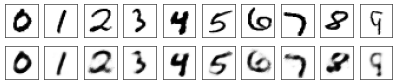

At epoch 3 total loss = 343.37714041341144


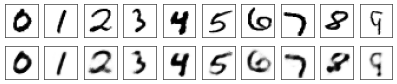

At epoch 4 total loss = 321.67782338867187


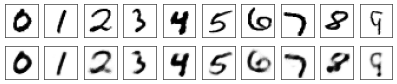

At epoch 5 total loss = 305.9856040771484


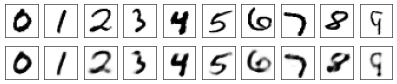

At epoch 6 total loss = 293.70050391438804


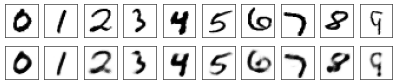

At epoch 7 total loss = 283.4261322998047


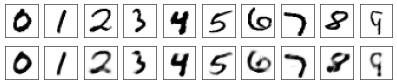

At epoch 8 total loss = 275.08219400227864


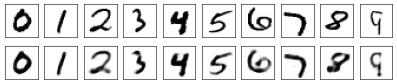

At epoch 9 total loss = 267.85310026855467


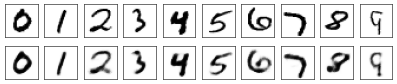

In [7]:
for epoch in range(10):
    tloss = 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device).view(-1, input_dim)
        out, mu = model(imgs)
        loss = ((out - imgs)**2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss += loss.item()

    print(f"At epoch {epoch} total loss = {tloss / len(train_loader)}")
    plot_digits()

In [8]:
scripted = torch.jit.script(model)
scripted.save("../models/AEDigits.pt")